# Making a Recurrent Neural Network with FRED Data
#### (Federal Reserve Economic Database)
###### Matthew Peach

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
import numpy as np

### Choosing a dataset
Time series data works well for Recurrent Neural Networks and economic data is easy to come by. The Federal Reserve as an API that I will use to load economic datasets. I've chosen to work with this dataset on the number of hires in the United States. I need a job soon, so this is kind of relevant to me right now. This data is also nice because there is a clear seasonal pattern that an RNN should be able to learn from.

#### Hires: Total Nonfram: https://fred.stlouisfed.org/series/JTUHIL

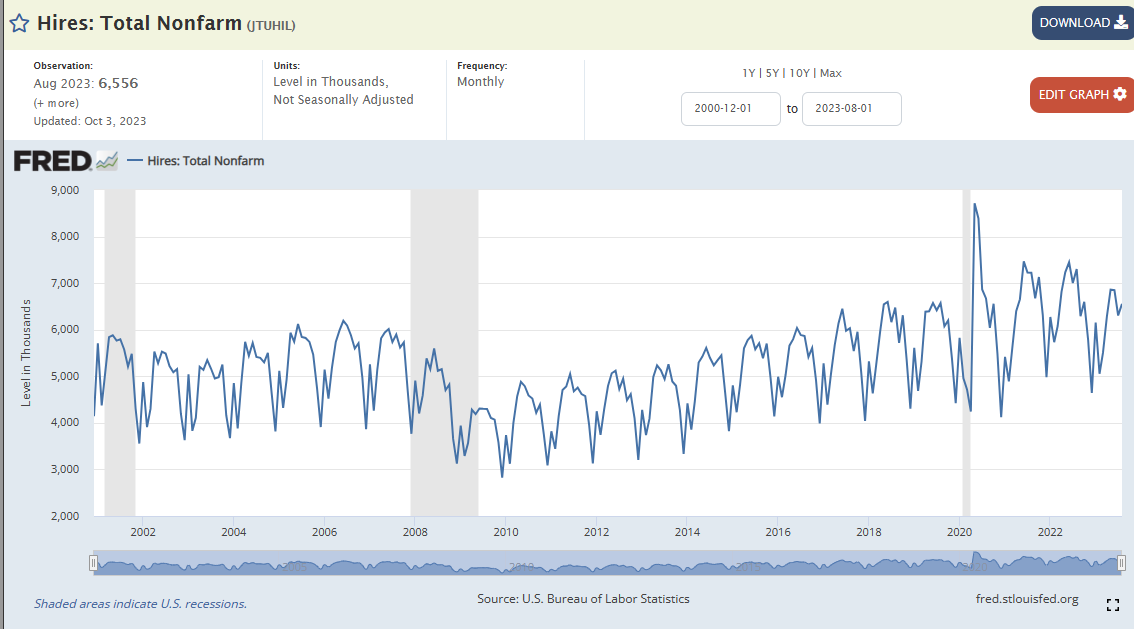

In [2]:
fred = Fred()

In [3]:
JTUHIL = fred.get_series("JTUHIL", observation_start="2000-12-01")
JTUHIL.tail()

2023-04-01    6277.0
2023-05-01    6862.0
2023-06-01    6848.0
2023-07-01    6305.0
2023-08-01    6556.0
dtype: float64

In [4]:
type(JTUHIL)

pandas.core.series.Series

Since I've gotten so used to working with Dataframes, I'm going to convert this Series to a Dataframe.

In [5]:
# Pandas Series to Dataframe
df = JTUHIL.to_frame()

In [6]:
df.head()

,0
2000-12-01,4141.0
2001-01-01,5707.0
2001-02-01,4376.0
2001-03-01,5069.0
2001-04-01,5842.0


That's not a descriptive column name...

In [7]:
df = df.rename(columns = {0: "Hires (thousands)"})

In [8]:
df.head()

,Hires (thousands)
2000-12-01,4141.0
2001-01-01,5707.0
2001-02-01,4376.0
2001-03-01,5069.0
2001-04-01,5842.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 273 entries, 2000-12-01 to 2023-08-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Hires (thousands)  273 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


Thankfully, the index is already DatetimeIndex!

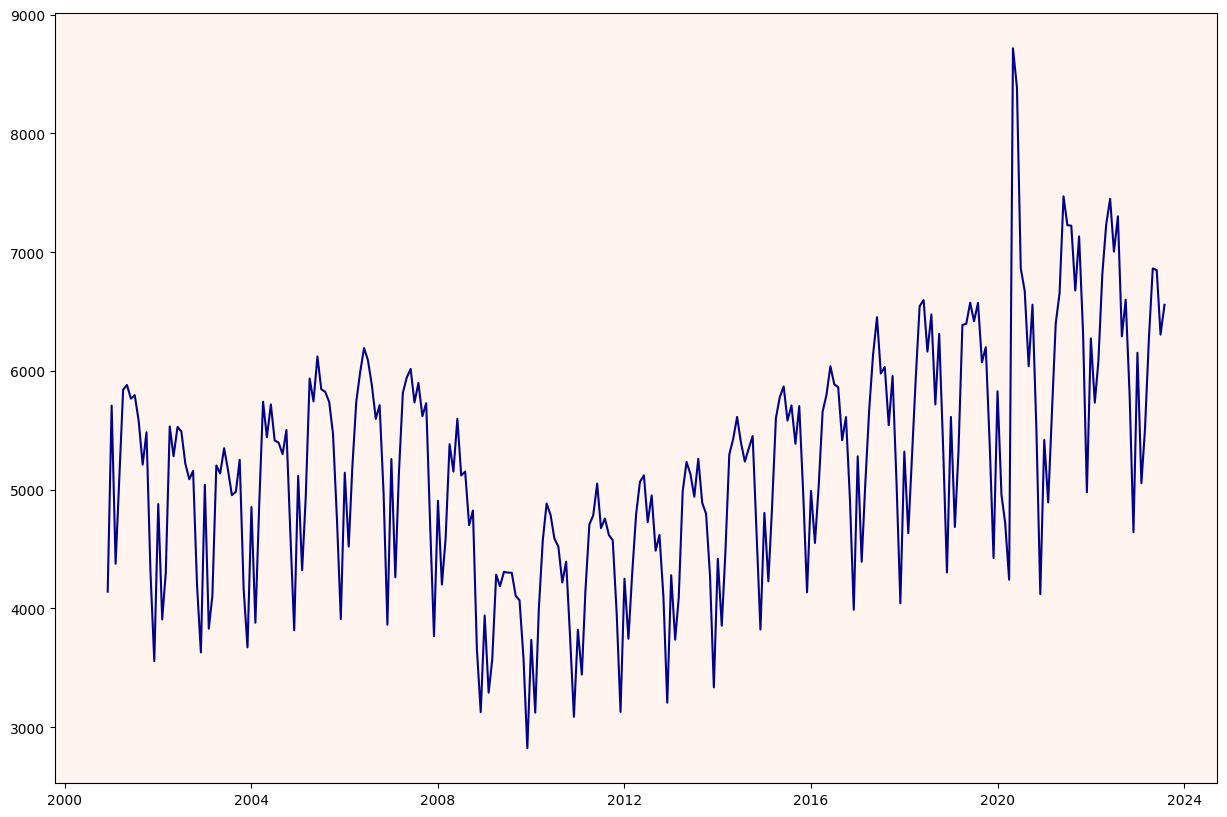

In [10]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_facecolor("seashell")
ax.plot(df, color = "darkblue")

## Train Test Split
I'm not totally sure what to use for the test size; the pattern should be yearly, so I'll go a little over a year (14 months) for now and adjust later if needed.

In [11]:
TEST_SIZE = 14
TEST_INDEX = len(df) - TEST_SIZE

In [12]:
# Up to and excluding
train = df.iloc[:TEST_INDEX]

# From to the end
test = df.iloc[TEST_INDEX:]

In [13]:
train.tail()

,Hires (thousands)
2022-02-01,5732.0
2022-03-01,6079.0
2022-04-01,6814.0
2022-05-01,7231.0
2022-06-01,7448.0


In [14]:
test.tail()

,Hires (thousands)
2023-04-01,6277.0
2023-05-01,6862.0
2023-06-01,6848.0
2023-07-01,6305.0
2023-08-01,6556.0


## Scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## TimeseriesGenerator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2023-10-23 19:57:49.805740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 19:57:49.805815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 19:57:49.805888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 19:57:49.818453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# For 12 months
BATCH_LENGTH = 12

In [19]:
generator = TimeseriesGenerator(scaled_train,    # X: Features
                                scaled_train,    # y: Labels (they are the same)
                                length = BATCH_LENGTH,
                                batch_size = 1)

In [20]:
validation_generator = TimeseriesGenerator(scaled_test, 
                                           scaled_test, 
                                           length = BATCH_LENGTH, 
                                           batch_size = 1)

Looking at the first batch to help understand this.

In [21]:
X,y = generator[0]

In [22]:
# Given these values, try to predict the next value...
X

array([[[0.2237869 ],
        [0.48948083],
        [0.26365796],
        [0.38123515],
        [0.51238548],
        [0.51900238],
        [0.49949101],
        [0.50441127],
        [0.46725484],
        [0.40515779],
        [0.45147608],
        [0.2521208 ]]])

In [23]:
# This is the true next value
y

array([[0.12453342]])

## The Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [25]:
# One feature because the feature is X from the generator
NUM_FEATURES = 1

In [26]:
model = Sequential()

model.add(LSTM(300,
               activation = "relu", 
               input_shape = (BATCH_LENGTH,
                              NUM_FEATURES)))
model.add(Dropout(0.5))

model.add(Dense(1))   # Output neuron

2023-10-23 19:57:51.779514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.


2023-10-23 19:57:51.789522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 19:57:51.789569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 19:57:51.794786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 19:57:51.794848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 19:57:51.794897: I tensorflow/compile

In [27]:
# MSE since this the predicted value is cotinuous
model.compile(optimizer = "adam", loss = "mse")

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               362400    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 362701 (1.38 MB)
Trainable params: 362701 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Early Stopping

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = "val_loss",
                           patience = 5)

## Training

In [30]:
%%time
model.fit(generator,
          epochs = 30,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/30


2023-10-23 19:57:57.144281: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x30daba60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-23 19:57:57.144334: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-10-23 19:57:57.150111: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-23 19:57:57.381854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-23 19:57:57.469351: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/247 [==============================] - 15s 45ms/step - loss: 0.0319 - val_loss: 0.0440
Epoch 2/30
247/247 [==============================] - 11s 44ms/step - loss: 0.0230 - val_loss: 0.0696
Epoch 3/30
247/247 [==============================] - 11s 44ms/step - loss: 0.0210 - val_loss: 0.0122
Epoch 4/30
247/247 [==============================] - 11s 45ms/step - loss: 0.0178 - val_loss: 0.0416
Epoch 5/30
247/247 [==============================] - 11s 46ms/step - loss: 0.0169 - val_loss: 0.0256
Epoch 6/30
247/247 [==============================] - 11s 44ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 7/30
247/247 [==============================] - 11s 44ms/step - loss: 0.0098 - val_loss: 0.0026
Epoch 8/30
247/247 [==============================] - 11s 45ms/step - loss: 0.0092 - val_loss: 0.0165
Epoch 9/30
247/247 [==============================] - 11s 45ms/step - loss: 0.0106 - val_loss: 2.2373e-04
Epoch 10/30
247/247 [==============================] - 11s 44ms/step - loss: 0.0092 - val

## Evaluation

<Axes: >

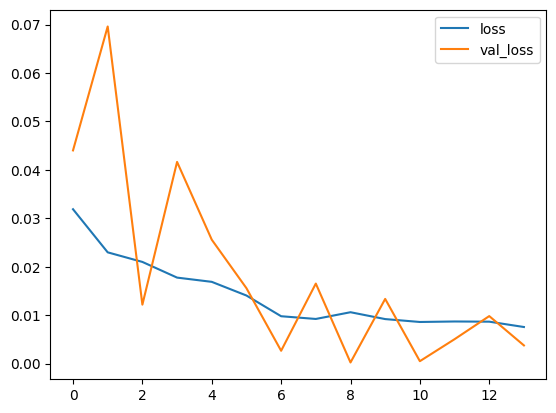

In [31]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [32]:
test_predictions = []

first_evaluation_batch = scaled_train[-BATCH_LENGTH:]
current_batch = first_evaluation_batch.reshape((1, BATCH_LENGTH, NUM_FEATURES))

for i in range(len(test)):
    # Prediction batch
    current_prediction = model.predict(current_batch)[0]
    # Add predicted value to test_predictions
    test_predictions.append(current_prediction)
    # Move on to the next batch, confusing slicing syntax...
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 23ms/step


These are scaled values, so they need to be transformed back to normal values.

In [33]:
test_predictions[0]

array([0.714151], dtype=float32)

In [34]:
unscaled_predictions = scaler.inverse_transform(test_predictions)

In [35]:
test["Predictions"] = unscaled_predictions

/tmp/ipykernel_7937/1962468329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"] = unscaled_predictions


In [36]:
test.head()

,Hires (thousands),Predictions
2022-07-01,7004.0,7031.206140
2022-08-01,7301.0,6998.916556
2022-09-01,6290.0,6729.862451
2022-10-01,6599.0,6902.669622
2022-11-01,5789.0,6466.256458


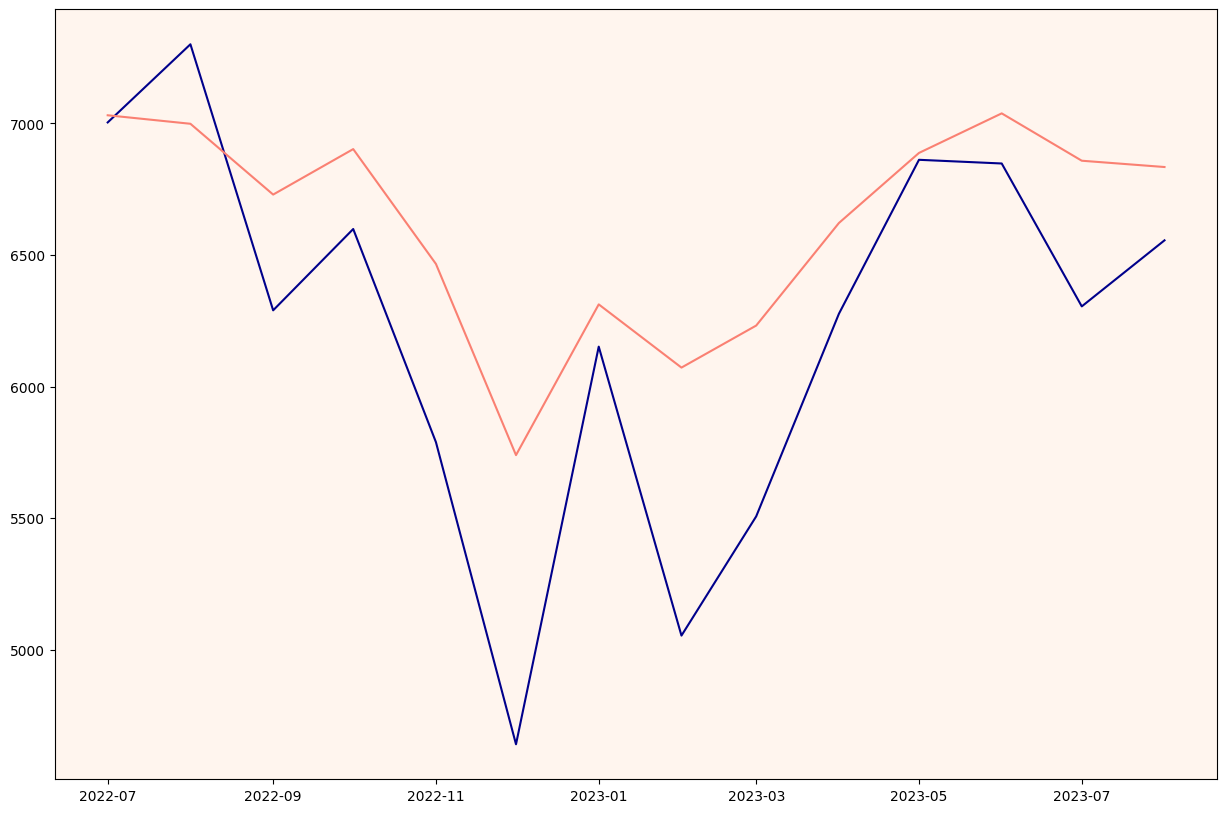

In [37]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_facecolor("seashell")
ax.plot(test["Hires (thousands)"], color = "darkblue")
ax.plot(test["Predictions"], color = "salmon")

Interesting that the prediction is higher, but follows the same general pattern. This does make a lot of sense if economic factors have slowed hiring down; based on past hiring trends, this model predicted more recent trends to be higher than they actually were.

# Forecasting

### Making a new Model using all of the data

In [38]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [39]:
generator = TimeseriesGenerator(scaled_full_data,
                                scaled_full_data,
                                length = BATCH_LENGTH,
                                batch_size = 1)

In [40]:
model = Sequential()

model.add(LSTM(300,
               activation = "relu", 
               input_shape = (BATCH_LENGTH,
                              NUM_FEATURES)))
model.add(Dropout(0.5))

model.add(Dense(1))   # Output neuron

In [41]:
# MSE since this the predicted value is cotinuous
model.compile(optimizer = "adam", loss = "mse")

In [42]:
%%time

# NOTE: No early stopping can happen here because there's no true values to compare the predictions to

model.fit(generator,
          epochs = 20)

Epoch 1/20
261/261 [==============================] - 13s 45ms/step - loss: 0.0276
Epoch 2/20
261/261 [==============================] - 12s 46ms/step - loss: 0.0197
Epoch 3/20
261/261 [==============================] - 12s 45ms/step - loss: 0.0218
Epoch 4/20
261/261 [==============================] - 12s 44ms/step - loss: 0.0157
Epoch 5/20
261/261 [==============================] - 12s 44ms/step - loss: 0.0140
Epoch 6/20
261/261 [==============================] - 12s 45ms/step - loss: 0.0124
Epoch 7/20
261/261 [==============================] - 12s 46ms/step - loss: 0.0110
Epoch 8/20
261/261 [==============================] - 12s 45ms/step - loss: 0.0117
Epoch 9/20
261/261 [==============================] - 11s 44ms/step - loss: 0.0116
Epoch 10/20
261/261 [==============================] - 11s 44ms/step - loss: 0.0094
Epoch 11/20
261/261 [==============================] - 12s 44ms/step - loss: 0.0101
Epoch 12/20
261/261 [==============================] - 12s 45ms/step - loss: 0.0094
E

In [43]:
forecast = []

# In this case, 1 time unit = 1 month
# Wanting to predict for all of 2024
time_units = 16

first_evaluation_batch = scaled_train[-BATCH_LENGTH:]
current_batch = first_evaluation_batch.reshape((1, BATCH_LENGTH, NUM_FEATURES))

for i in range(time_units):
    # Prediction batch
    current_prediction = model.predict(current_batch)[0]
    # Add predicted value to test_predictions
    forecast.append(current_prediction)
    # Move on to the next batch, confusing slicing syntax...
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 23ms/step


In [44]:
# Unscaling
forecast = scaler.inverse_transform(forecast)

In [45]:
# These need to be labeled with a date
forecast

array([[7034.41640902],
       [6970.14569068],
       [6657.98166013],
       [6794.1844604 ],
       [6216.08279359],
       [5266.59821248],
       [6040.2793014 ],
       [5775.75779486],
       [6074.55519104],
       [6607.51530814],
       [6911.56127238],
       [7047.45843315],
       [6838.14666319],
       [6767.87908697],
       [6568.23817253],
       [6558.05194557]])

In [46]:
# Looking at last date; I need to start a month after this
df.tail(1)

,Hires (thousands)
2023-08-01,6556.0


More frequency codes under "DateOffset objects": https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects

In [47]:
forecast_index = pd.date_range(start = "2023-09-01", 
                               periods = time_units, 
                               freq = "MS"      # MS = "Monthly Start"/"Month Begin"
                               )

In [48]:
forecast_df = pd.DataFrame(data = forecast,
                           index = forecast_index,
                           columns = ["Forecast"])

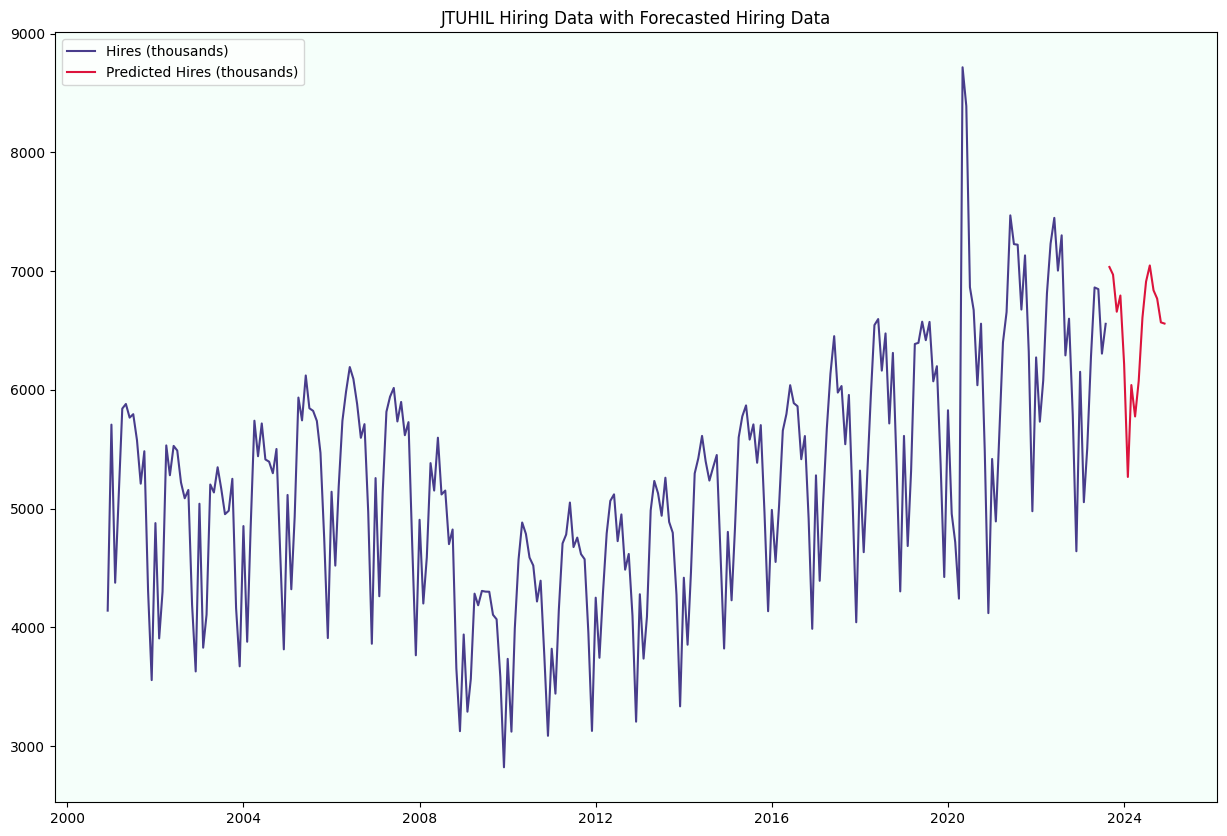

In [60]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title("JTUHIL Hiring Data with Forecasted Hiring Data")
ax.set_facecolor("mintcream")
ax.plot(df, color = "darkslateblue", label = "Hires (thousands)")
ax.plot(forecast_df, color = "crimson", label = "Predicted Hires (thousands)") # Forecasted predictions
plt.legend(loc = "upper left")

That looks reasonable!

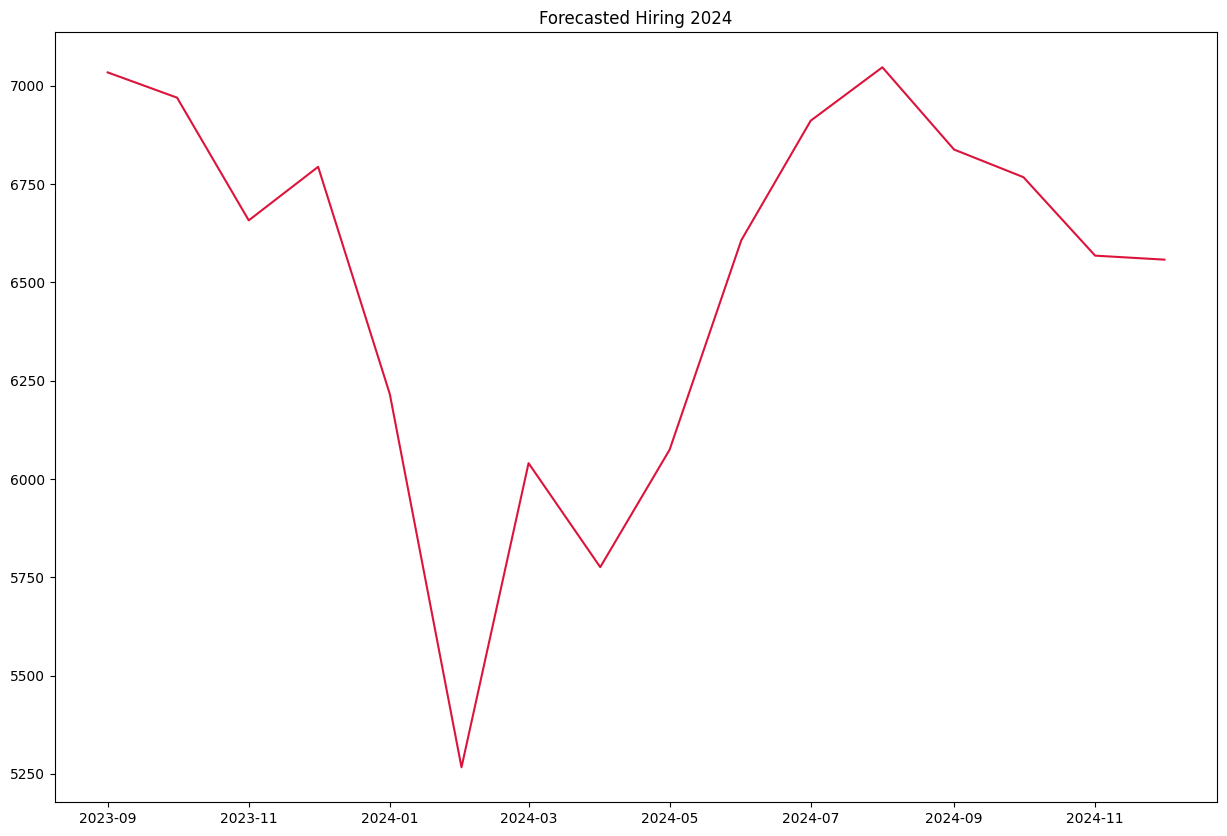

In [62]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title("Forecasted Hiring 2024")
ax.plot(forecast_df, color = "crimson", label = "Predicted Hires (thousands)") # Forecasted predictions

## Final Thoughts
It looks like hiring is consistently lowest at the start of each year. My model's forecasted hiring numbers for 2024 *look* correct, but it's impossible to tell how correct they are until the dates actually pass and the data becomes available.